In [1]:
import matplotlib.pyplot as plt
import numpy as np

from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_power_spectra

from timescales.sim import sim_spikes_synaptic
from timescales.est import fit_acf
from timescales.est.psd import convert_knee_val

from fooof import FOOOF

def fit_psd(spikes, fs, f_range, fooof_init=None, n_jobs=-1):
    
    freqs, powers = compute_spectrum(spikes, fs, f_range=f_range)
    
    if fooof_init is not None:
        fm = FOOOF(aperiodic_mode='knee', verbose=False, **fooof_init)
    else:
        fm = FOOOF(aperiodic_mode='knee', verbose=False)
        
    fm.fit(freqs, powers, f_range)
    
    knee = fm.get_params('aperiodic', 'knee')
    exp = fm.get_params('aperiodic', 'exponent')
    
    knee_freq, knee_tau = convert_knee_val(knee, exponent=exp)
    
    return fm, knee_freq, knee_tau

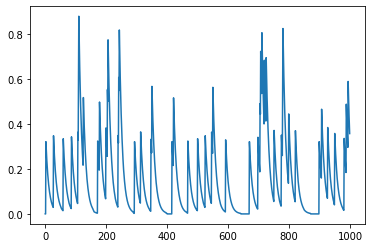

In [2]:
n_seconds = 10
fs = 1000
tau = .01
mu = 20
    
probs, spikes = sim_spikes_synaptic(n_seconds, fs, tau, mu=mu)

plt.plot(probs[:1000])

In [3]:
np.random.seed(0)

niters = 100
f_range = (1, 100)

powers = np.zeros((100, 100))
corrs = np.zeros((100, 100))
probs = np.zeros((100, 10000))
fms = []
kf = []
kt = []

taus = []

for i in range(niters):
    
    _probs, _ = sim_spikes_synaptic(n_seconds, fs, tau, mu=mu)
    probs[i] = _probs
    
    freqs, _powers = compute_spectrum(_probs, fs, f_range=f_range)
    powers[i] = _powers
    
    fm, knee_freq, knee_tau, = fit_psd(_probs, fs, f_range)
    fms.append(fm)
    kf.append(knee_freq)
    kt.append(knee_tau)
    
    _corrs, _params_acf = fit_acf(_probs, 100)
    corrs[i] = _corrs
    
    taus.append(_params_acf[1]/fs)

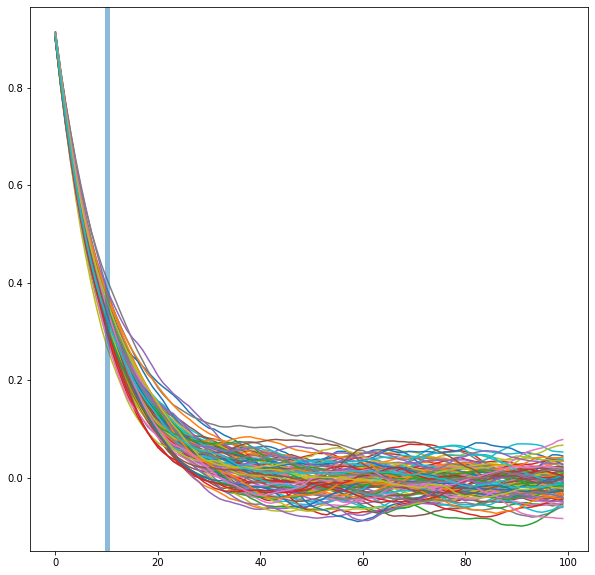

In [4]:
plt.figure(figsize=(10, 10))
for c in corrs:
    plt.plot(c)
plt.axvline(10, lw=5, alpha=.5);

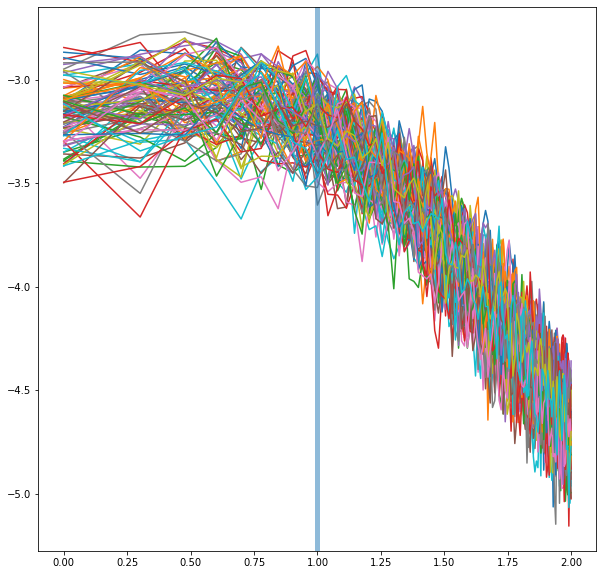

In [5]:
plt.figure(figsize=(10, 10))
for p in powers:
    plt.plot(np.log10(freqs), np.log10(p))
    
plt.axvline(np.log10(10), lw=5, alpha=.5);

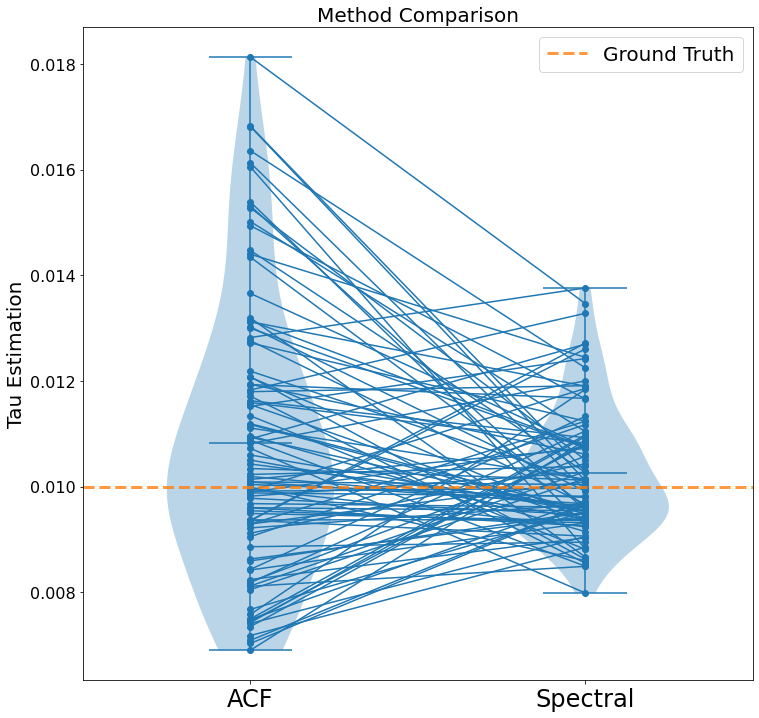

In [6]:
plt.figure(figsize=(12, 12))


for a, b in zip(kt, taus):
    plt.plot([1, 2], [a, b], 'o-', color='C0')
    
plt.violinplot([kt, taus], showmeans=True)
plt.axhline(.01, color='C1', ls='dashed', alpha=.8, lw=3, label='Ground Truth')


plt.xticks([1, 2], labels=['ACF', 'Spectral'], fontsize=24)
plt.yticks(fontsize=16)
plt.xlim(0.5, 2.5)
plt.ylabel('Tau Estimation', fontsize=20)
plt.title('Method Comparison', fontsize=20)
plt.legend(fontsize=20)

plt.savefig('method_comparison.png')

In [7]:
from neurodsp.filt import filter_signal

from neurodsp.sim import sim_damped_oscillation
from scipy.optimize import curve_fit

def fit(xs, fs, tau, cos_freq, cos_gamma, var_exp, var_cos, return_sum=True):
    
    exp = np.exp(-np.arange(len(xs))/(tau * fs)) * var_exp
    cos = sim_damped_oscillation(1, len(xs), cos_freq, cos_gamma) * var_cos
    
    if not return_sum:
        return exp, cos

    return exp+cos

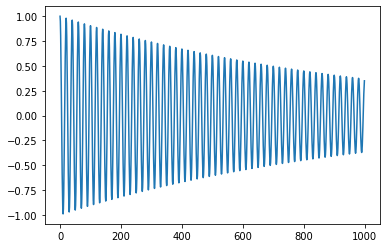

In [8]:
cos_freq = 50
cos_gamma = 1
var_cos = 1
cos = sim_damped_oscillation(1, 1000, cos_freq, cos_gamma) * var_cos

plt.plot(cos)

Sim Tau:  0.1
Est Tau:  0.09499999999999999


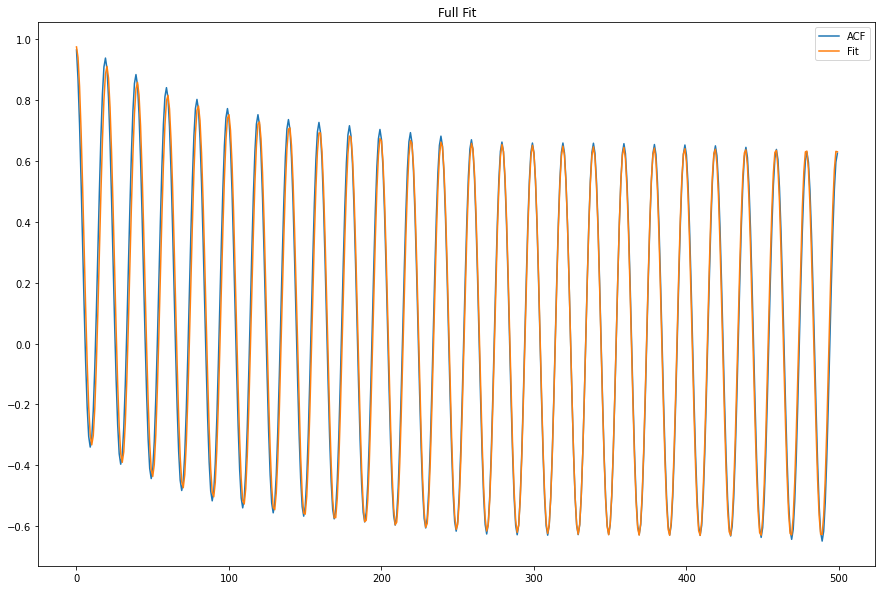

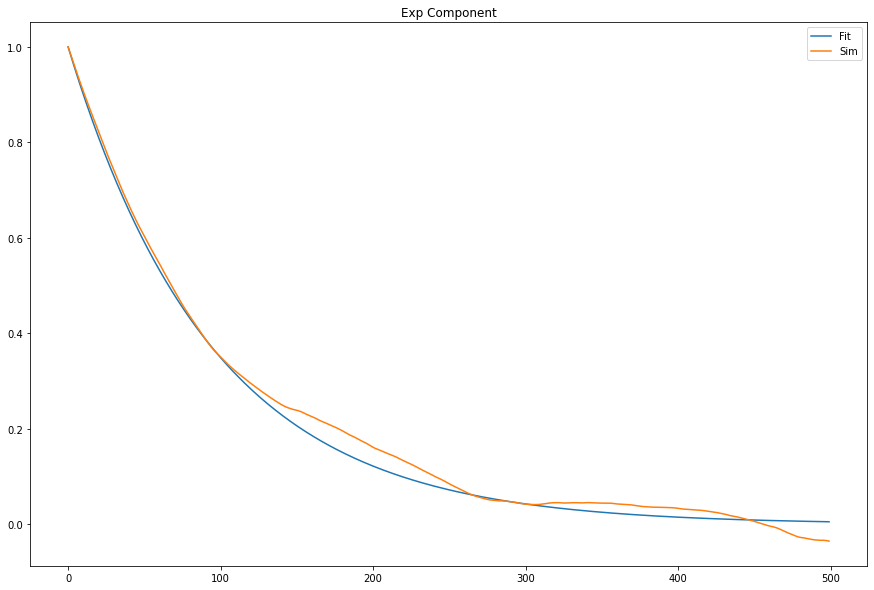

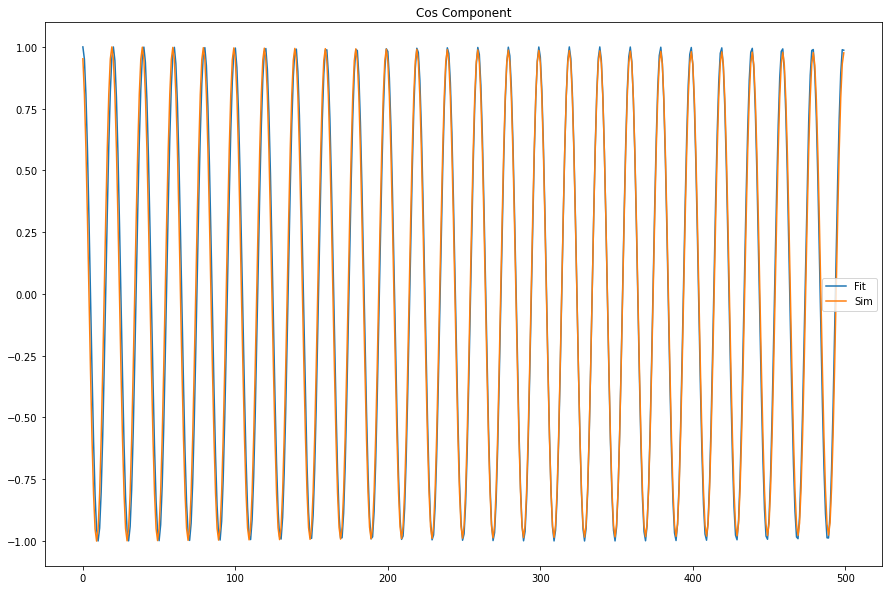

In [9]:
#np.random.seed(3)

n_seconds = 20
nlags = 500
fs = 1000
mu = 20
freq = 50
tau = .1

# Simulate
exp, _ = sim_spikes_synaptic(n_seconds, fs, tau, mu=mu)


cos = np.cos(np.linspace(0, (freq * len(exp) / fs)* 2 * np.pi, len(exp)))
cos = (cos + 1) / 2

variances = (1, .5)


probs = (exp * variances[0]) + (cos * variances[1])
corrs, params_acf = fit_acf(probs, nlags)


_probs = (exp * variances[0])
exp_sim, _ = fit_acf(_probs, nlags)
_probs = (cos * variances[1])
cos_sim, _ = fit_acf(_probs, nlags)

# Estimate cosine frequency
xs = np.arange(len(corrs))
ys = corrs

f, p = compute_spectrum(ys, len(ys))
freq_guess = int(np.argmax(p))


# Tau estimation
lower_freq = freq_guess - 5
lower_freq = 0.1 if lower_freq <= 0 else lower_freq
upper_freq = freq_guess + 5
ys_filt = filter_signal(ys, len(ys), 'bandpass', (lower_freq, upper_freq),
                        n_seconds=.8, remove_edges=False)

inds = np.where(np.diff(np.sign(np.diff(ys_filt))) > 0)[0] + 1

exp_est = ys[inds].copy()
exp_est -= np.min(exp_est)
exp_est_interp = np.interp(np.arange(xs[inds][0], xs[inds][-1]+1), xs[inds], exp_est)
exp_est_bl = exp_est_interp - exp_est_interp[0] / np.exp(1)

_inds = np.where(exp_est_bl < 0)[0]

if len(_inds) == 0:
    tau_guess = inds[0] / fs
else:
    pts = [_inds[0]-2, _inds[0]-1]
    tau_guess = (pts[np.argmin(exp_est_bl[pts])] + inds[0]) / fs

p0 = [tau_guess, freq_guess, 1, 1, 1]
#p0 = [tau, freq_guess, 1, 1, 1]
#bounds = [
#    (tau * .1, freq_guess-1, 0, .1, .1),
#    (tau * 1, freq_guess+1, 1, 1,  1)
#]

bounds = [
    (tau_guess * .1, freq_guess-1, 0, .1, .1),
    (tau_guess * 1, freq_guess+1, 1, 1,  1)
]


params, _ = curve_fit(lambda xs, t, f, g, ve, vc: fit(xs, fs, t, f, g, ve, vc),
                      xs, ys, p0=p0, bounds=bounds, maxfev=1000)

ys_hat = fit(xs, fs, *params)
e, c = fit(xs, fs, *params, return_sum=False)

# Results
print('Sim Tau: ', tau)
print('Est Tau: ', params[0])

plt.figure(0, figsize=(15, 10))
plt.title('Full Fit')
plt.plot(ys, label='ACF')
plt.plot(ys_hat, label='Fit')
plt.legend()

plt.figure(1, figsize=(15, 10))
plt.title('Exp Component')
plt.plot(e / np.max(e), label='Fit')
plt.plot(exp_sim / np.max(exp_sim), label='Sim')
plt.legend();

plt.figure(2, figsize=(15, 10))
plt.title('Cos Component')
plt.plot(c / np.max(c), label='Fit')
plt.plot(cos_sim / np.max(cos_sim), label='Sim')
plt.legend();